In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from review_analyzer.plots import show_image

show_image('https://i.imgur.com/XLD0c0o.png')

# 1. Descripción del Problema

El proyecto desarrolla un sistema que analiza emociones y perspectiva (positiva o negativa) en reseñas online sobre productos y servicios, usando NLP y machine learning, para generar insights útiles a marcas y negocios.

Diccionario de datos
| Variable            | Tipo       | Descripción |
|---------------------|------------|-------------|
| `user`              | Object    | Nombre de usuario |
| `user_id`           | int    | ID del usuario |
| `text`              | object | Comentario realizado por el usuario |
| `like`              | int  | Cantidad de likes en un comentario |
| `reply_count`       | int    | Cantidad de respuestas en un comentario |
| `timestamp`         | object  | Codigo de la fecha |
| `fecha_legible`     | object  | fecha del comentario realizado |

# 2. Análisis Exploratorio de Datos (EDA)

Objetivo: Comprender el dataset y su distribución para tomar decisiones del modelo.

Dataset: Datos obtenidos mediante consulta a las APIs oficiales de plataformas digitales, integrados y preparados para el EDA y limpieza.

In [ ]:
from review_analyzer.config import TIKTOK_COMMENTS
import pandas as pd


In [4]:
df = pd.read_csv(TIKTOK_COMMENTS)
df.head()

,user,comment,time,likes,reply_count,origen
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso .,2025-02-21 10:25:01,296,28,comments-perfume.csv
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv
2,jozahel,Me dejan el precio ? No me dejen su Wsp que no...,2025-02-21 08:29:51,337,38,comments-perfume.csv
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4651 entries, 0 to 4650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user         4650 non-null   object
 1   comment      4651 non-null   object
 2   time         4651 non-null   object
 3   likes        4651 non-null   int64 
 4   reply_count  4651 non-null   int64 
 5   origen       4651 non-null   object
dtypes: int64(2), object(4)
memory usage: 218.1+ KB


In [6]:
df['comment_length'] = df['comment'].astype(str).apply(len)

In [7]:
from review_analyzer.plots import plot_histo

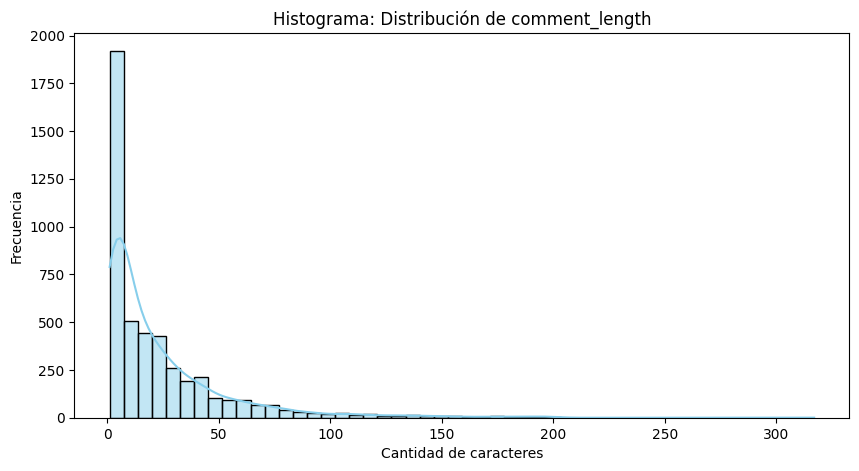

In [8]:
plot_histo(df, 'comment_length')

La gran mayoría de comentarios tienen menos de 20 caracteres.

A partir de los ~100 caracteres, la frecuencia cae casi a cero, y solo aparecen unos pocos comentarios muy largos (outliers).

Tal vez valga la pena establecer un límite superior de longitud para filtrar entradas irrelevantes.

In [9]:
from review_analyzer.plots import plot_comments_by_time

In [10]:
df['time'] = pd.to_datetime(df['time'], errors='coerce')

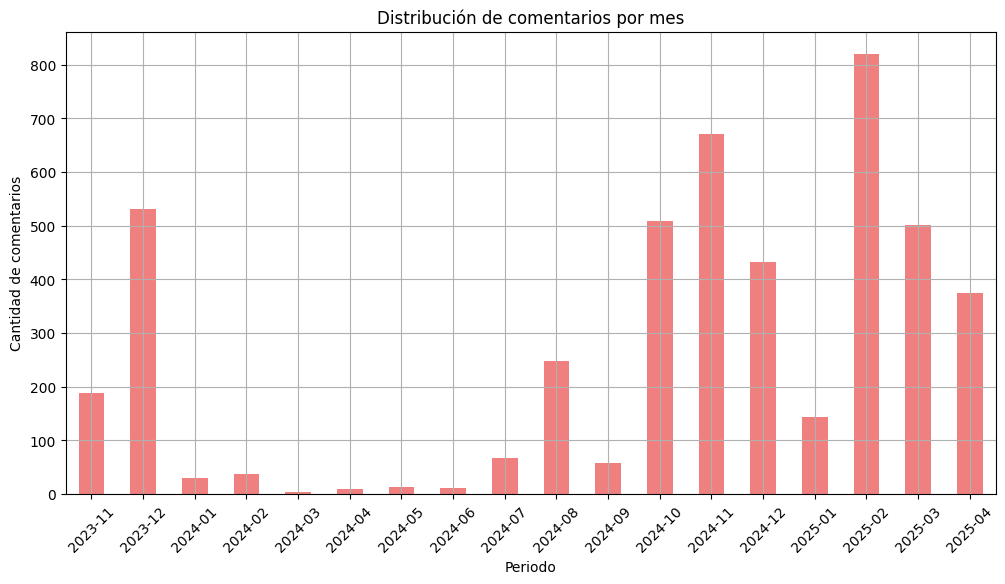

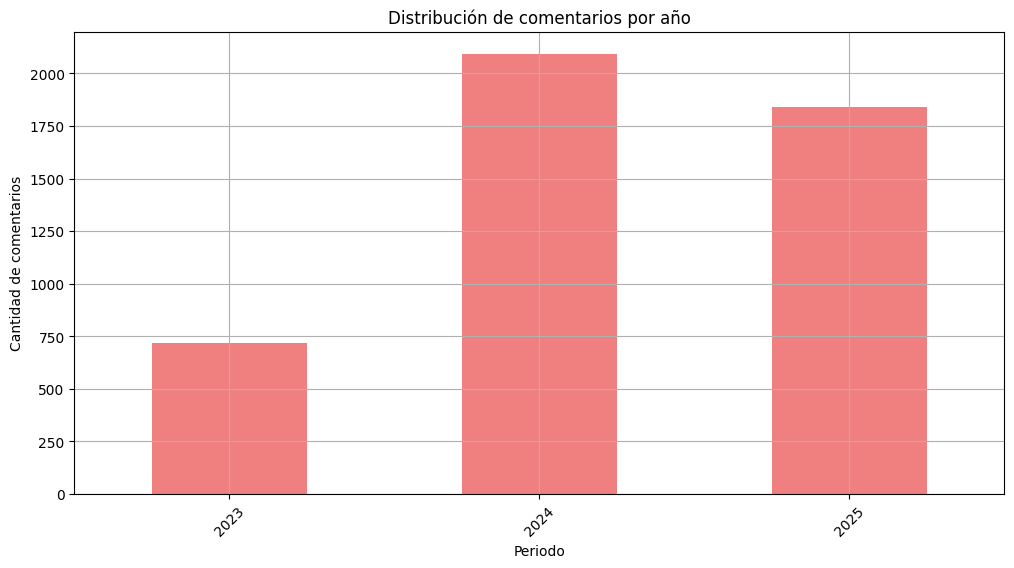

In [11]:
plot_comments_by_time(df, time_column='time', period='M')
plot_comments_by_time(df, time_column='time', period='Y')


Los comentarios no están distribuidos uniformemente en el tiempo: la mayoría de los datos provienen de 2024 y 2025, mientras que 2023 tiene menor representación, por lo que es importante considerar el sesgo temporal al analizar y modelar los datos.

In [12]:
df.describe()

,time,likes,reply_count,comment_length
count,4651,4651.000000,4651.000000,4651.000000
mean,2024-10-24 19:16:20.322081280,3.874006,0.199097,23.452376
min,2023-11-29 19:59:12,0.000000,0.000000,1.000000
25%,2024-09-19 16:26:40.500000,0.000000,0.000000,4.000000
50%,2024-11-27 19:27:25,0.000000,0.000000,12.000000
75%,2025-02-22 09:10:39,0.000000,0.000000,31.000000
max,2025-04-30 22:25:32,3140.000000,38.000000,317.000000
std,NaN,66.311410,1.589186,30.278358


- La mayoría de los comentarios son cortos, sin likes ni respuestas.

- Existen pocos comentarios “virales” con muchos likes o respuestas, que elevan los máximos y promedios.

- El promedio es 23.45 caracteres, con mediana de 12, lo que indica que la distribución está sesgada a la derecha (algunos comentarios son muy largos y elevan el promedio).

- El engagement general (likes y replies) es bajo para la mayoría, pero los outliers dominan las métricas agregadas.

In [13]:
from review_analyzer.plots import plot_correlation_scatter

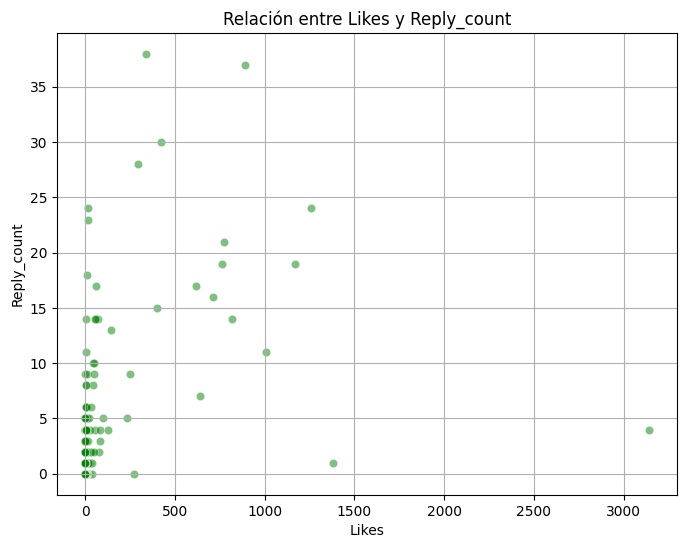

In [14]:
plot_correlation_scatter(df, 'likes', 'reply_count', color='green')

No se observa una correlación clara entre likes y reply_count: la mayoría de los comentarios tiene valores bajos, y los casos con muchos likes no muestran un aumento proporcional en respuestas.

In [15]:
from review_analyzer.plots import plot_language_distribution

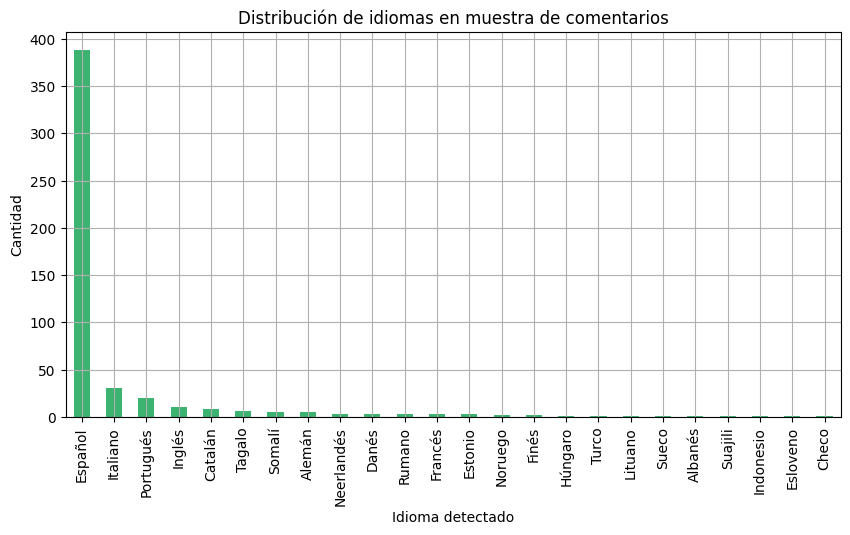

In [16]:
plot_language_distribution(df['comment'], sample_size=500)

La mayoría de los comentarios están en español, con muy poca representación de otros idiomas; se puede trabajar principalmente sobre datos en español sin necesidad de procesamiento multilingüe general.

### Resumen general
- La mayoría de los comentarios son cortos (mediana ≈12 caracteres) y no generan likes ni respuestas; el engagement promedio es bajo, pero existen outliers que distorsionan las métricas (máximos muy altos).

- Los histogramas muestran una distribución sesgada, donde pocos comentarios concentran mucha interacción.
- El scatterplot entre likes y reply_count sugiere una relación débil o ruidosa: la mayoría de los puntos se agrupan en valores bajos, sin una tendencia clara.
- Se recomienda detectar el idioma de los comentarios porque, aunque se asume que la mayoría será en español por contexto temporal y geográfico (2024-2025), es necesario confirmarlo para preparar procesos de limpieza y el análisis de sentimiento.

In [17]:
from review_analyzer.config import EXP_SNAPSHOT_PATH

In [18]:
df.to_csv(EXP_SNAPSHOT_PATH, index=False, encoding='utf-8')

# 3. Limpieza y Preprocesamiento



In [69]:
df = pd.read_csv(EXP_SNAPSHOT_PATH)
df.head()

,user,comment,time,likes,reply_count,origen,comment_length
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso .,2025-02-21 10:25:01,296,28,comments-perfume.csv,37
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47
2,jozahel,Me dejan el precio ? No me dejen su Wsp que no...,2025-02-21 08:29:51,337,38,comments-perfume.csv,99
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv,126


In [70]:
df.shape

(4651, 7)

In [71]:
import emoji

In [72]:
has_emoji = df['comment'].apply(lambda x: any(char in emoji.EMOJI_DATA for char in x))
df_with_emoji = df[has_emoji]

df_with_emoji[['comment']].head(10)

,comment
1,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅
4,"El olor no perdura, pero si huele muy rico, mu..."
7,400 so quien dice Yooo ❓
9,yo soy fiel a mi Axe de chocolate 😌😌😌
12,gente sean sincero le gana al one millon?🤔🤔
74,No me gusto la verdad 😩
77,colonia de dj mario 😮‍💨
78,o me sigue y te paso uno mejor ☺️
111,precio para mi hijo quiero 🥺
125,Mano lo compré y mis amigos decían que olía a ...


Los emojis en solitario suelen contener emociones muy claras (amor, risa, tristeza, enojo), por lo que si no los traducimos, se perdería esa información clave.

In [76]:
from review_analyzer.dataset import clean_basic_text_preserve_emojis

In [77]:
df['comment_cleaned'] = df['comment'].apply(clean_basic_text_preserve_emojis)
df.head()

,user,comment,time,likes,reply_count,origen,comment_length,comment_cleaned
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso .,2025-02-21 10:25:01,296,28,comments-perfume.csv,37,le gana sauvage dior ufff perfumaso.
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅
2,jozahel,Me dejan el precio ? No me dejen su Wsp que no...,2025-02-21 08:29:51,337,38,comments-perfume.csv,99,Me dejan el precio? No me dejen su Wsp que no ...
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18,Cuál es su precio?
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv,126,"El olor no perdura, pero si huele muy rico, mu..."


In [78]:
df['comment'] = df['comment_cleaned']
df.drop(columns=['comment_cleaned'], inplace=True)
df.head()

,user,comment,time,likes,reply_count,origen,comment_length
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso.,2025-02-21 10:25:01,296,28,comments-perfume.csv,37
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47
2,jozahel,Me dejan el precio? No me dejen su Wsp que no ...,2025-02-21 08:29:51,337,38,comments-perfume.csv,99
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv,126


In [79]:
df.shape

(4651, 7)

In [80]:
df['word_count'] = df['comment'].str.split().apply(len)

In [81]:
df[df['word_count'] < 5][['comment']].sample(20, random_state=42)

,comment
2758,Usan mayoreo!?
652,Perfume
547,Número
4435,😳😳😳
4553,donde lo puedo conseguir
3044,hola
499,🤣
2819,is that richaldison😮‍💨
1372,😁😁😁
4422,es riquísimo 🥰


In [82]:
word_count = 20
samples = 20

In [83]:
subset = df[df['word_count'] > word_count][['comment']].sample(20, random_state=42)
for c in subset['comment']:
    print(c, '\n' + '-' * 80)

son fake así no vienen esas jordan 4 retro yo me compre una acá en la misma nike acá en eeuu y es diferente 
--------------------------------------------------------------------------------
la verdad si son buenas pero hay de calidad buena y mala la verdad el mejor peeo mas caro es Sony despues LG 
--------------------------------------------------------------------------------
yo lo tengo y me encanta. ahora comprendo, tengo 50 años 🤪😍👌👍. aún así, hay que recordar que depende mucho de nuestro PH!. bendiciones hermosas!! 🙏 ☺️❤️ 
--------------------------------------------------------------------------------
El primero me encanta, te lo he visto y lo he buscado en amazon, lo he comprado por 53€! Gracias amigo! 😀 
--------------------------------------------------------------------------------
todas las marcas de televisiónes tienes sus gamas de entrada, media y premium TODAS. no pueden comparar una gama de entrada de x marca con una gama premium. Al final siempre va ganar LG en tecnolo

Comentarios muy cortos (<3 palabras) → si son solo emojis, se conservan; si son palabras genéricas, pueden filtrarse por baja relevancia.

Comentarios muy largos (>100 palabras) → aunque raros, muestran opiniones detalladas con carga emocional; se conservan tras revisión, no se eliminan automáticamente.

In [84]:
df.head()

,user,comment,time,likes,reply_count,origen,comment_length,word_count
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso.,2025-02-21 10:25:01,296,28,comments-perfume.csv,37,6
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47,9
2,jozahel,Me dejan el precio? No me dejen su Wsp que no ...,2025-02-21 08:29:51,337,38,comments-perfume.csv,99,19
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18,4
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv,126,26


### Extracción de embeddings BERT

En este paso usamos un modelo BERT para convertir los comentarios textuales en representaciones numéricas (embeddings). 

Estos vectores capturan información semántica, incluyendo contexto, tono y significado, y servirán como entrada para los modelos de análisis emocional.


In [85]:
from review_analyzer.dataset import extract_bert_embeddings

In [87]:
comments = df['comment'].tolist()

In [88]:
bert_embeddings = extract_bert_embeddings(comments, batch_size=16)

In [90]:
from review_analyzer.config import BERT_EMBEDDINGS

In [91]:
import numpy as np

In [92]:
np.save(BERT_EMBEDDINGS, bert_embeddings)

#### Resumen

El dataset ha sido limpiado y preprocesado para usar con BERT:
- Solo limpieza mínima aplicada (URLs, hashtags, menciones).
- Emojis y mayúsculas preservados.
- No se aplicó stopword removal, lematización ni tokenización manual.
- Embeddings BERT generados y guardados.

# 3.5 Etiquetado de datos

Selección de muestra representativa (golden set) + semi-supervisado

In [101]:
df.head()

,user,comment,time,likes,reply_count,origen,comment_length,word_count
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso.,2025-02-21 10:25:01,296,28,comments-perfume.csv,37,6
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47,9
2,jozahel,Me dejan el precio? No me dejen su Wsp que no ...,2025-02-21 08:29:51,337,38,comments-perfume.csv,99,19
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18,4
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, mu...",2025-02-21 10:56:35,15,23,comments-perfume.csv,126,26


In [103]:
df.shape

(4651, 8)

In [104]:
from transformers import pipeline

In [105]:
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu


In [106]:
df['bert_sentiment'] = df['comment'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [ ]:
pd.set_option('display.max_colwidth', None)

for label in df['bert_sentiment'].unique():
    print(f"\nEjemplos para {label}:")
    print(df[df['bert_sentiment'] == label][['comment']].head(5))


Ejemplos para LABEL_1:
                                                                                                                          comment
0                                                                                            le gana sauvage dior ufff perfumaso.
1                                                                                 Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅
2                              Me dejan el precio? No me dejen su Wsp que no pienso escribirles, solo díganme el precio por favor
3                                                                                                              Cuál es su precio?
4  El olor no perdura, pero si huele muy rico, muy top en cuando a olor 🫦, pero no dura!!! Parece más un toilette por la duración

Ejemplos para LABEL_2:
                                          comment
9           yo soy fiel a mi Axe de chocolate 😌😌😌
78              o me sigue y te paso uno mejor ☺️
156  el mejor perfume 

In [107]:
df['bert_sentiment'].value_counts()

bert_sentiment
LABEL_1    3580
LABEL_2     962
LABEL_0     109
Name: count, dtype: int64

In [111]:
label_map = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

df['bert_sentiment'] = df['bert_sentiment'].map(label_map)

In [112]:
df.head()

,user,comment,time,likes,reply_count,origen,comment_length,word_count,bert_sentiment
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso.,2025-02-21 10:25:01,296,28,comments-perfume.csv,37,6,neutral
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47,9,neutral
2,jozahel,"Me dejan el precio? No me dejen su Wsp que no pienso escribirles, solo díganme el precio por favor",2025-02-21 08:29:51,337,38,comments-perfume.csv,99,19,neutral
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18,4,neutral
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, muy top en cuando a olor 🫦, pero no dura!!! Parece más un toilette por la duración",2025-02-21 10:56:35,15,23,comments-perfume.csv,126,26,neutral


In [178]:
import review_analyzer.plots as p

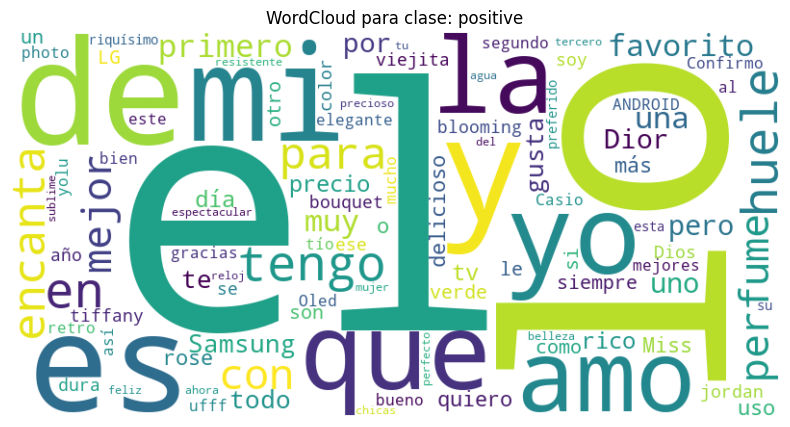

In [181]:
class_name = 'positive'

p.plot_wordcloud_for_class(df, text_col='comment', class_col='bert_sentiment', class_value=class_name)


In [113]:
from review_analyzer.config import BERT_SENTIMENT_PATH

In [114]:
df.to_csv(BERT_SENTIMENT_PATH, index=False)

labeled_golden_set = pd.read_csv(GOLDEN_SET_LABELED_PATH)

labeled_golden_set = pd.read_csv(GOLDEN_SET_LABELED_PATH)

df = pd.concat([df, labeled_golden_set['label'].rename('emotion_label')], axis=1)

df.head()

print(df['emotion_label'].unique())
print(df['emotion_label'].isnull().sum())

Terminado el etiquetado (golden set), preparamos modelo semi-supervisado

golden_set = df[df['emotion_label'].notnull()]
unlabeled_set = df[df['emotion_label'].isnull()]

In [116]:
from review_analyzer.config import BERT_SENTIMENT_PATH

In [119]:
df = pd.read_csv(BERT_SENTIMENT_PATH)

In [121]:
df.head()

,user,comment,time,likes,reply_count,origen,comment_length,word_count,bert_sentiment
0,Joel Equiño Espinoza.,le gana sauvage dior ufff perfumaso.,2025-02-21 10:25:01,296,28,comments-perfume.csv,37,6,neutral
1,Klaus Heinz,Si lo dice Flavia laos prefiero usar Yanbal 😅😅😅,2025-02-21 19:53:11,400,15,comments-perfume.csv,47,9,neutral
2,jozahel,"Me dejan el precio? No me dejen su Wsp que no pienso escribirles, solo díganme el precio por favor",2025-02-21 08:29:51,337,38,comments-perfume.csv,99,19,neutral
3,Pilar Acha Mendez,Cuál es su precio?,2025-02-21 20:20:06,4,11,comments-perfume.csv,18,4,neutral
4,Bas 🫀,"El olor no perdura, pero si huele muy rico, muy top en cuando a olor 🫦, pero no dura!!! Parece más un toilette por la duración",2025-02-21 10:56:35,15,23,comments-perfume.csv,126,26,neutral


In [150]:
from review_analyzer.plots import plot_correlation_heatmap

In [153]:
numeric_columns = ['likes', 'reply_count', 'comment_length']
target_numeric = pd.factorize(df['bert_sentiment'])[0]
corr_df = pd.concat([df[numeric_columns], pd.Series(target_numeric, name='bert_sentiment_numeric')], axis=1)

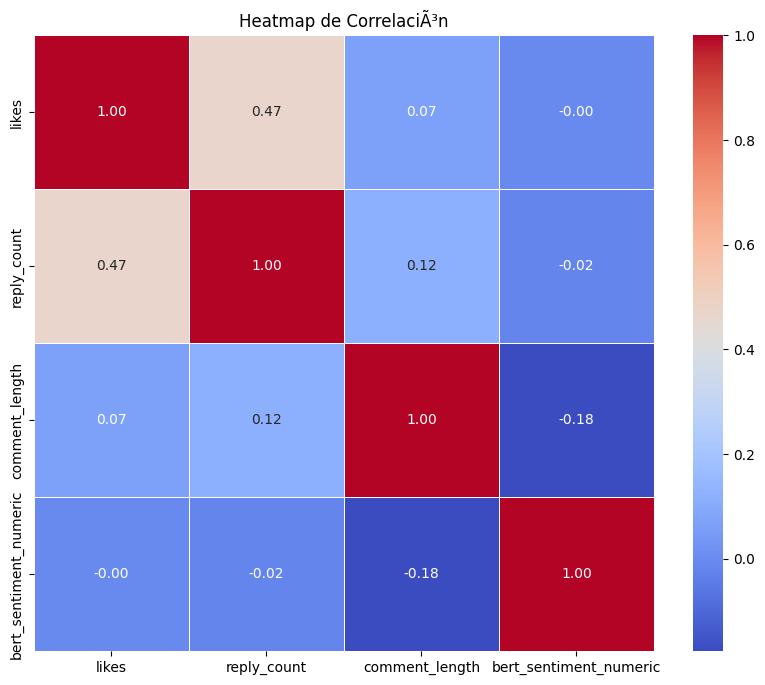

In [154]:
plot_correlation_heatmap(corr_df, corr_df.columns)

No hay correlación lineal fuerte entre las métricas de popularidad (likes, reply_count) y las etiquetas de sentimiento, lo cual indica que las clases emocionales no dependen directamente de la popularidad ni de la extensión textual.

In [155]:
from review_analyzer.plots import plot_class_distribution

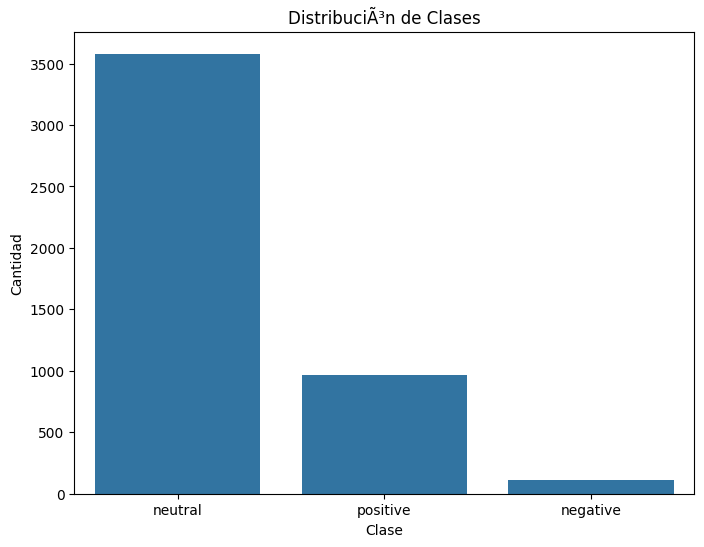

In [156]:
plot_class_distribution(df, 'bert_sentiment')

El gráfico muestra un fuerte desbalance de clases, donde la mayoría de comentarios son neutrales, pocos positivos y muy pocos negativos. Será necesario considerar técnicas de balanceo antes del modelado.

In [176]:
import review_analyzer.plots as p

# 5. Feature Engineering

Transformar texto en vectores numéricos utilizables por el modelo, y preparar las variables numéricas adicionales (likes, reply_count) para que puedan integrarse adecuadamente.

In [ ]:
df.iloc[419]

user                             ab_17
comment               Sotelo la boca 😣
time               2025-03-28 23:44:36
likes                                1
reply_count                          0
origen            comments-perfume.csv
comment_length                      24
word_count                           4
Name: 419, dtype: object